In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import joblib
from numpy import asarray
from imageio.v3 import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils
import pywt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
def  image_segmentaion(img):


    img = np.float32(img)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(img,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    colors = np.concatenate((center[0],center[1]),axis=None)

    col = 0 if np.mean(center[0]) > np.mean(center[1]) else 1
    res = center[label.flatten()]
    mask = res.reshape((img.shape))

    for i in range(len(mask)):
      for j in range(len(mask[i])):

        if mask[i][j][0] == center[col][0] and mask[i][j][1] == center[col][1] and mask[i][j][2] == center[col][2]: mask[i][j] = [0, 0, 0]
        else: mask[i][j] = [1, 1, 1]

    edges = cv2.Canny(mask,100,200)
    image = np.multiply(mask,img)

    return image,colors,edges

In [ ]:
def gaborfilter(img):

    ksize = 15
    sigma = 5
    theta = 1*np.pi/2
    lamda = 1*np.pi/4
    gamma=0.9
    phi = 0.8

    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

    return fimg

In [ ]:
def wavelet_transform(img):
  LL, (image, HL, HH) = pywt.dwt2(img, 'bior1.3')
  return image

In [ ]:
metadata = pd.read_csv('/content/drive/MyDrive/PR dataset/HAM10000_metadata.csv')

In [ ]:
label_encoder = LabelEncoder()
metadata['dx_label'] = label_encoder.fit_transform(metadata['dx'])

In [ ]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


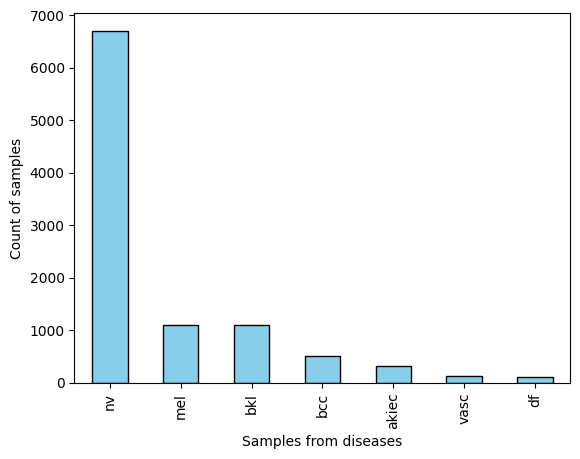

In [ ]:
label_counts = metadata['dx'].value_counts()
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.set_xlabel('Samples from diseases')
ax.set_ylabel('Count of samples')
plt.show()

Handling Imbalanced Data

In [ ]:
original_class_counts = np.bincount(metadata["dx_label"])

ros = RandomOverSampler(sampling_strategy={0: 500, 3: 500, 6: 500}, random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(metadata, metadata["dx_label"])

rus = RandomUnderSampler(sampling_strategy={1: 500, 2: 1000, 4: 1000, 5: 1000}, random_state=42)
metadata, y_train_resampled = rus.fit_resample(X_train_oversampled, y_train_oversampled)

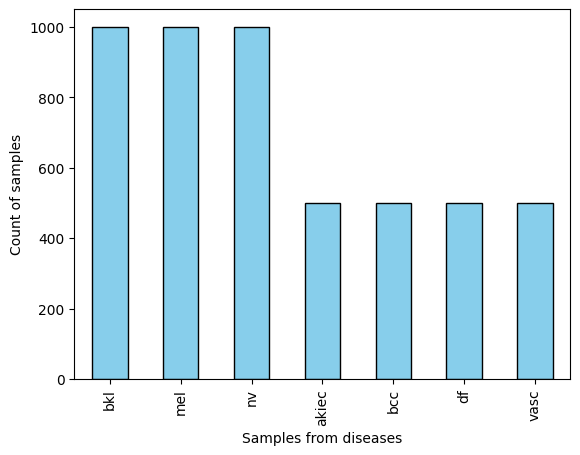

In [ ]:
label_counts = metadata['dx'].value_counts()
ax = label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
ax.set_xlabel('Samples from diseases')
ax.set_ylabel('Count of samples')
plt.show()

In [ ]:
class_labels= {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
def display_samples_per_class(metadata, image_dir):
    classes = metadata['dx'].unique()

    for skin_class in classes:
        class_samples = metadata[metadata['dx'] == skin_class].head(4)

        plt.figure(figsize=(12, 3))
        plt.suptitle(f'Samples for Class: {class_labels[skin_class]}')

        for i, (_, row) in enumerate(class_samples.iterrows()):
            img_path = os.path.join(image_dir, row['image_id'] + '.jpg')
            image = imread(img_path)

            plt.subplot(1, 4, i + 1)
            plt.imshow(image)
            plt.title(f"ID: {row['image_id']}")

            plt.axis('off')

        plt.show()


Few Samples of different Classes

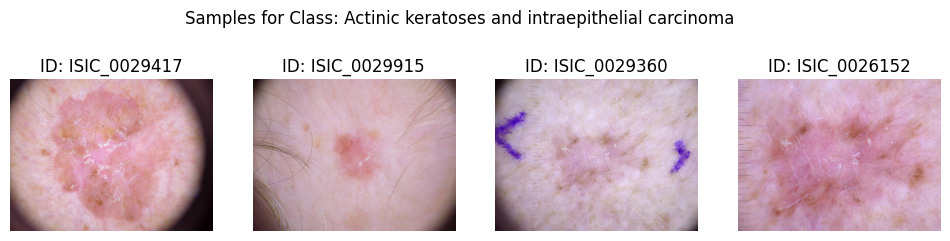

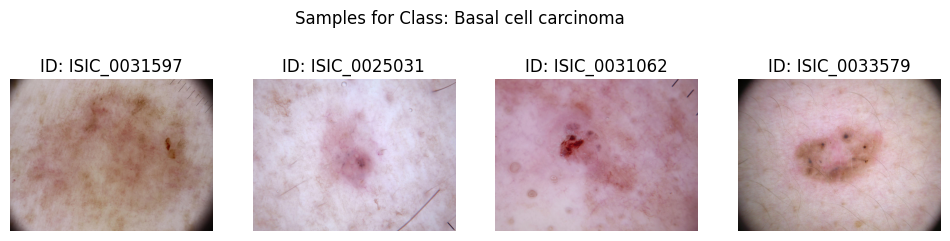

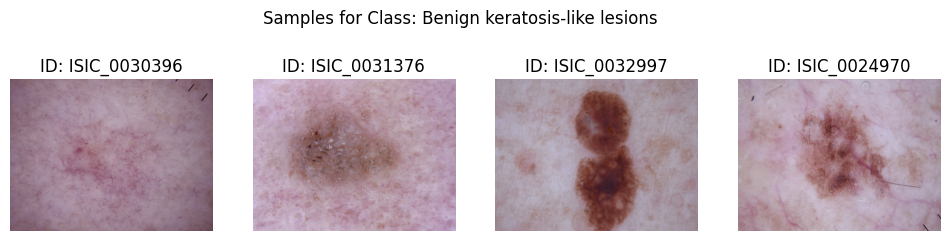

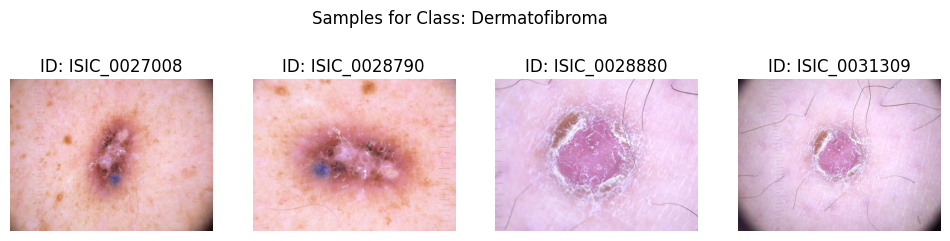

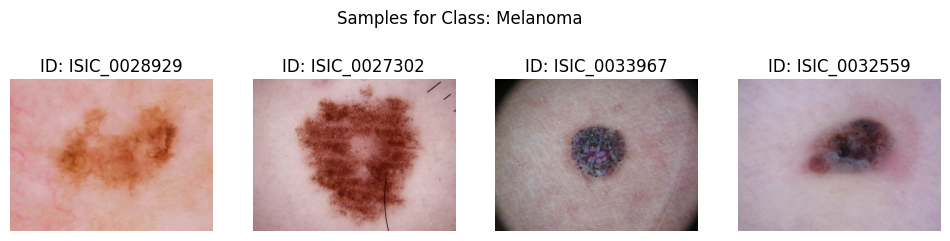

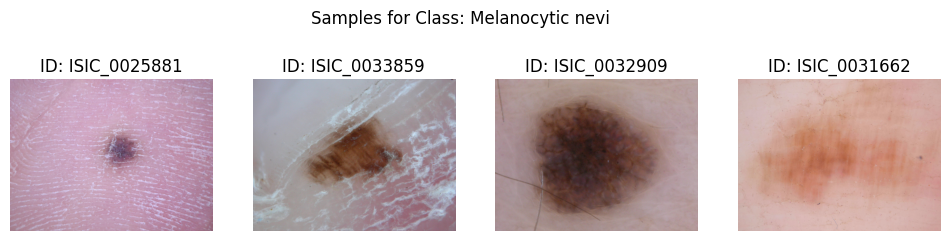

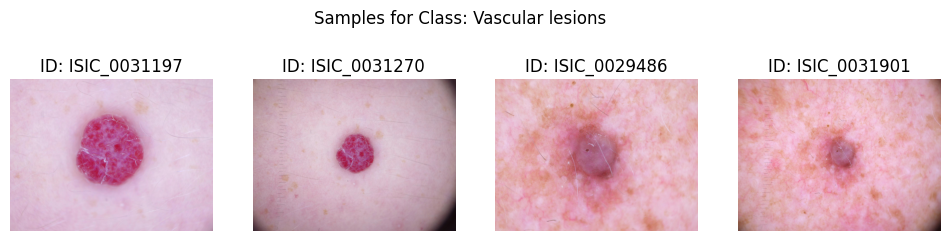

In [ ]:
image_dir = '/content/drive/MyDrive/PR dataset/SD_Images'
display_samples_per_class(metadata, image_dir)

Above Samples after noise removal and downscaling

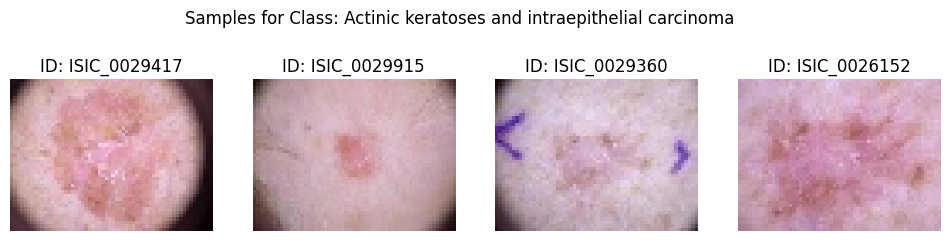

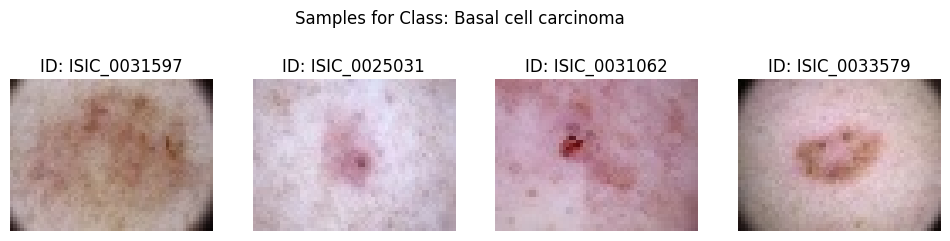

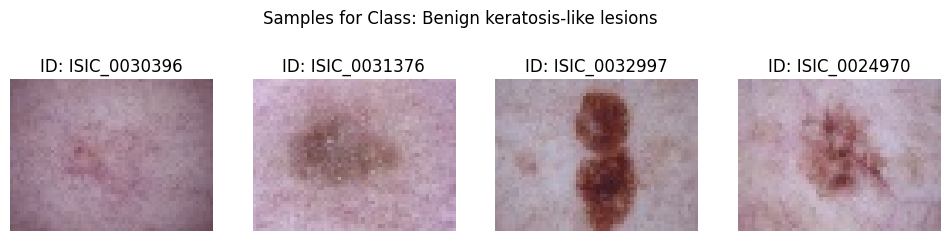

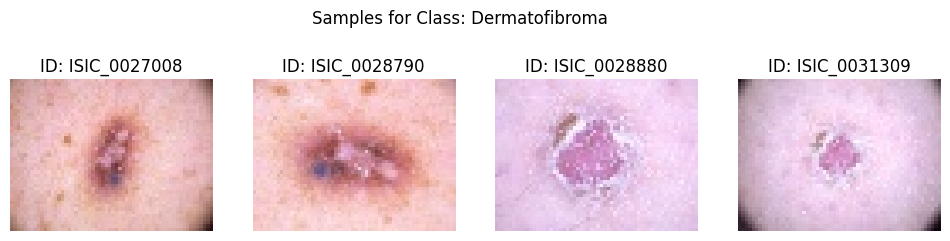

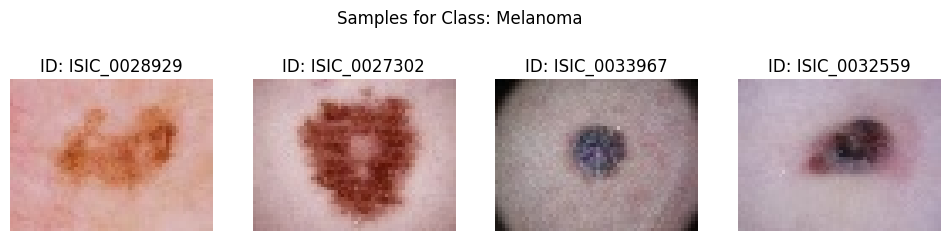

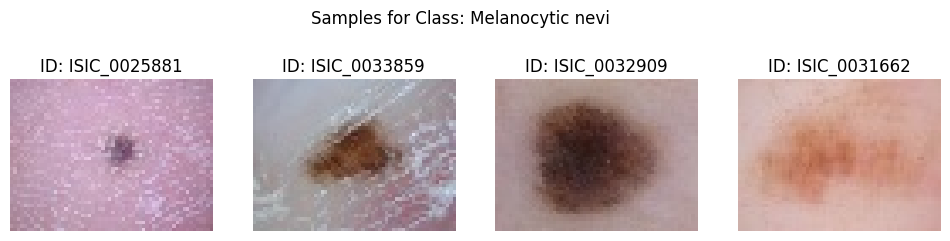

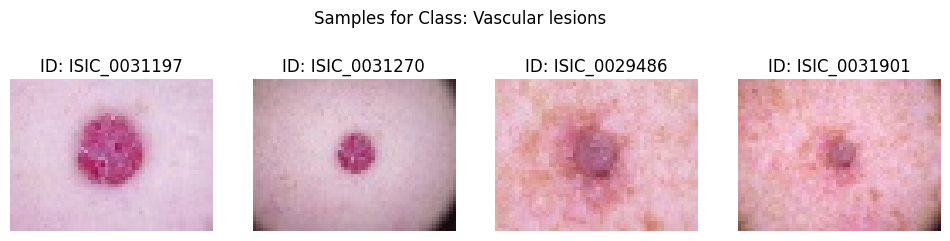

In [ ]:
image_dir = '/content/drive/MyDrive/PR dataset/Scaled_Images'
display_samples_per_class(metadata, image_dir)

In [ ]:
class DatasetLoader(Dataset):

    def __init__(self,root_dir,mode):
        self.metadata = metadata
        self.root_dir = root_dir
        self.mode = mode

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self,i):

        if torch.is_tensor(i):
            i = i.tolist()
        disease = self.metadata.iloc[i,7]
        img_name = os.path.join(self.root_dir,
                                f"{self.metadata.iloc[i, 1]}.jpg")
        image = imread(img_name)
        image,colors,edges = image_segmentaion(image)
        if self.mode==0:
          features = gaborfilter(image)
        if self.mode==1:
           features = wavelet_transform(image)
        if self.mode==2:
           features = edges

        sample = {'features': features.flatten(), 'color' : colors, 'disease': disease.astype(float)}
        return sample

Feature Extraction - Mode 0 (Texture Analysis)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=0)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  # print(X["features"].shape)
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, random_state=42)

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
joblib.dump(rfc, '/content/drive/MyDrive/PR dataset/Trained_models/rfc_v00.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/rfc_v00.joblib']

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.55      0.62       111
         1.0       0.47      0.41      0.44       105
         2.0       0.40      0.52      0.45       190
         3.0       0.98      0.99      0.98        94
         4.0       0.50      0.54      0.51       196
         5.0       0.65      0.55      0.60       193
         6.0       0.93      0.86      0.89       111

    accuracy                           0.60      1000
   macro avg       0.66      0.63      0.64      1000
weighted avg       0.62      0.60      0.61      1000



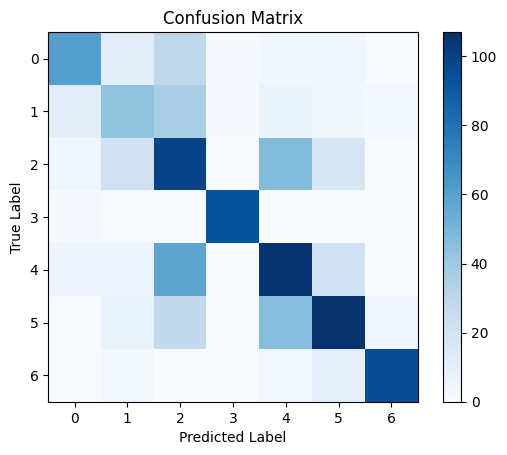

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(class_weight='balanced')

In [ ]:
svm_model.fit(X_train,y_train)

SVC(class_weight='balanced')

In [ ]:
joblib.dump(svm_model, '/content/drive/MyDrive/PR dataset/Trained_models/svc_v00.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/svc_v00.joblib']

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57       111
         1.0       0.38      0.50      0.44       105
         2.0       0.48      0.41      0.44       190
         3.0       0.82      0.96      0.88        94
         4.0       0.55      0.60      0.58       196
         5.0       0.66      0.50      0.57       193
         6.0       0.79      0.83      0.81       111

    accuracy                           0.59      1000
   macro avg       0.61      0.63      0.61      1000
weighted avg       0.59      0.59      0.59      1000



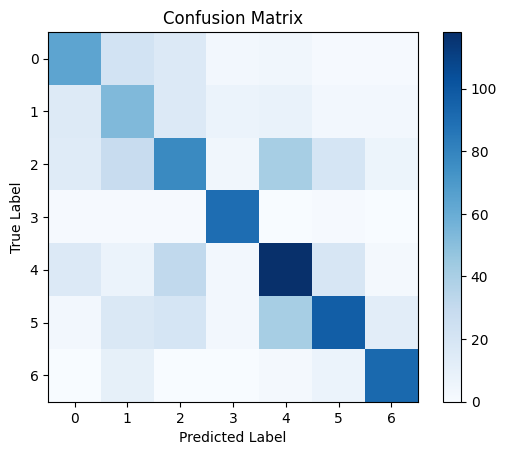

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
joblib.dump(xgbc, '/content/drive/MyDrive/PR dataset/Trained_models/xgboost_v00.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/xgboost_v00.joblib']

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60       111
         1.0       0.50      0.40      0.44       105
         2.0       0.42      0.55      0.48       190
         3.0       0.98      0.99      0.98        94
         4.0       0.52      0.56      0.54       196
         5.0       0.71      0.59      0.64       193
         6.0       0.97      0.93      0.95       111

    accuracy                           0.63      1000
   macro avg       0.68      0.65      0.66      1000
weighted avg       0.64      0.63      0.63      1000



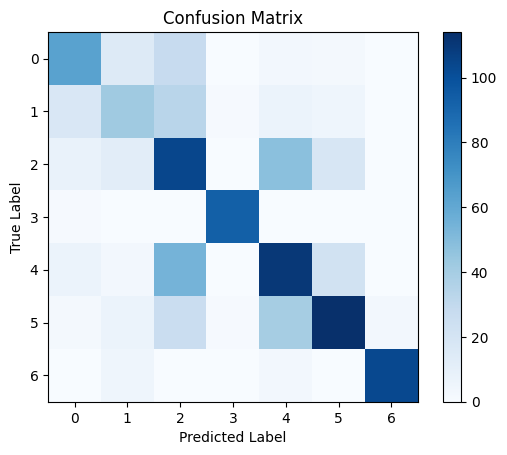

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_size = 3060
num_classes = 7

ann = models.Sequential()

ann.add(layers.InputLayer(input_shape=(input_size,)))

ann.add(layers.Dense(512, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(256, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(128, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(num_classes, activation='softmax'))

ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1567232   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 7)                

In [ ]:
X_train.shape

(4000, 3060)

In [ ]:
X_train = np.vstack(X_train)
y_train = np.vstack(y_train)

In [ ]:
y_train.shape

(4000, 1)

In [ ]:
ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 4s 29ms/step - loss: 122.8905 - accuracy: 0.1522 - val_loss: 1.9362 - val_accuracy: 0.1937
Epoch 2/50
100/100 [==============================] - 3s 34ms/step - loss: 2.2381 - accuracy: 0.1941 - val_loss: 1.9132 - val_accuracy: 0.1988
Epoch 3/50
100/100 [==============================] - 3s 33ms/step - loss: 1.9181 - accuracy: 0.2072 - val_loss: 1.8943 - val_accuracy: 0.1988
Epoch 4/50
100/100 [==============================] - 3s 29ms/step - loss: 1.9058 - accuracy: 0.2006 - val_loss: 1.8782 - val_accuracy: 0.1988
Epoch 5/50
100/100 [==============================] - 2s 24ms/step - loss: 1.8928 - accuracy: 0.2050 - val_loss: 1.8710 - val_accuracy: 0.1988
Epoch 6/50
100/100 [==============================] - 2s 25ms/step - loss: 1.8903 - accuracy: 0.2056 - val_loss: 1.8690 - val_accuracy: 0.1988
Epoch 7/50
100/100 [==============================] - 2s 25ms/step - loss: 1.8919 - accuracy: 0.2084 - val_loss: 1.8672 - val_accuracy: 0.19

In [ ]:
ann.save('/content/drive/MyDrive/PR dataset/Trained_models/ann_v00.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


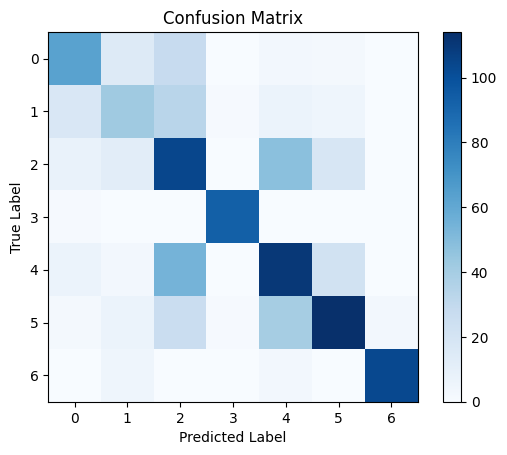

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Feature Extraction - Mode 1 (Wavelet Transform)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=1)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  # print(X["features"].shape)
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, random_state=42)

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
joblib.dump(rfc, '/content/drive/MyDrive/PR dataset/Trained_models/rfc_v01.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/rfc_v01.joblib']

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.57      0.64       111
         1.0       0.52      0.34      0.41       105
         2.0       0.42      0.56      0.48       190
         3.0       1.00      0.97      0.98        94
         4.0       0.50      0.53      0.51       196
         5.0       0.58      0.60      0.59       193
         6.0       0.97      0.81      0.88       111

    accuracy                           0.61      1000
   macro avg       0.67      0.63      0.64      1000
weighted avg       0.63      0.61      0.61      1000



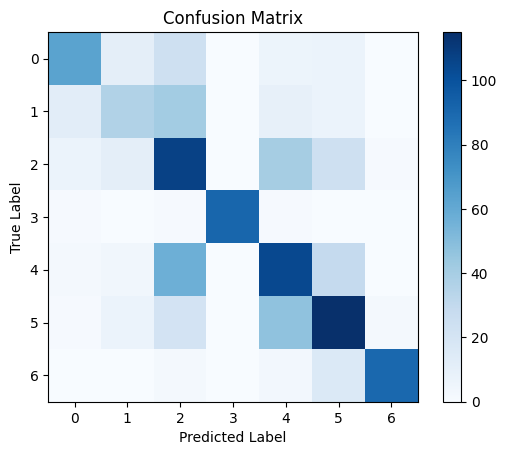

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train,y_train)

SVC(class_weight='balanced')

In [ ]:
joblib.dump(svm_model, '/content/drive/MyDrive/PR dataset/Trained_models/svm_v01.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/svm_v01.joblib']

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.46      0.38      0.41       111
         1.0       0.32      0.30      0.31       105
         2.0       0.46      0.45      0.45       190
         3.0       0.36      0.63      0.46        94
         4.0       0.49      0.46      0.47       196
         5.0       0.64      0.42      0.51       193
         6.0       0.51      0.70      0.59       111

    accuracy                           0.47      1000
   macro avg       0.46      0.48      0.46      1000
weighted avg       0.48      0.47      0.47      1000



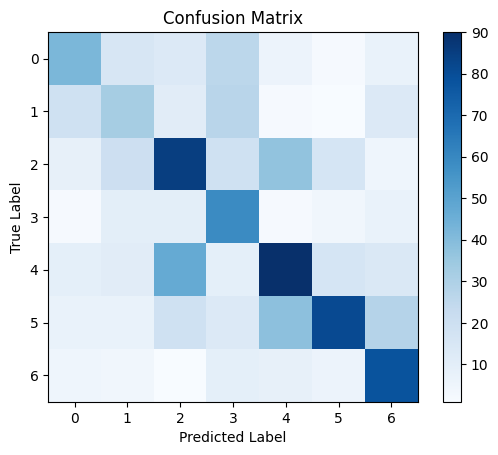

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
joblib.dump(xgbc, '/content/drive/MyDrive/PR dataset/Trained_models/xgbc_v01.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/xgbc_v01.joblib']

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.57      0.64       111
         1.0       0.54      0.50      0.52       105
         2.0       0.43      0.56      0.49       190
         3.0       0.97      0.99      0.98        94
         4.0       0.54      0.55      0.54       196
         5.0       0.67      0.62      0.65       193
         6.0       1.00      0.91      0.95       111

    accuracy                           0.64      1000
   macro avg       0.70      0.67      0.68      1000
weighted avg       0.66      0.64      0.65      1000



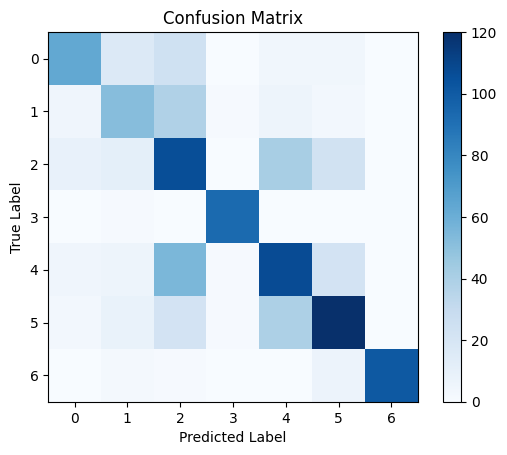

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_size = 6120
num_classes = 7

ann = models.Sequential()

ann.add(layers.InputLayer(input_shape=(input_size,)))

ann.add(layers.Dense(512, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(256, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(128, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(num_classes, activation='softmax'))

ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               3133952   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                

In [ ]:
X_train = np.vstack(X_train)

In [ ]:
y_train = np.vstack(y_train)

In [ ]:
ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 6s 45ms/step - loss: 42.0782 - accuracy: 0.1769 - val_loss: 1.9354 - val_accuracy: 0.2087
Epoch 2/50
100/100 [==============================] - 4s 43ms/step - loss: 2.0878 - accuracy: 0.1975 - val_loss: 1.9226 - val_accuracy: 0.2025
Epoch 3/50
100/100 [==============================] - 6s 62ms/step - loss: 2.0661 - accuracy: 0.1897 - val_loss: 1.9077 - val_accuracy: 0.1988
Epoch 4/50
100/100 [==============================] - 5s 50ms/step - loss: 2.1082 - accuracy: 0.2081 - val_loss: 1.8870 - val_accuracy: 0.1988
Epoch 5/50
100/100 [==============================] - 4s 45ms/step - loss: 1.9965 - accuracy: 0.1950 - val_loss: 1.8811 - val_accuracy: 0.2000
Epoch 6/50
100/100 [==============================] - 5s 52ms/step - loss: 2.0500 - accuracy: 0.2056 - val_loss: 1.8782 - val_accuracy: 0.2037
Epoch 7/50
100/100 [==============================] - 6s 58ms/step - loss: 2.0536 - accuracy: 0.1956 - val_loss: 1.8895 - val_accuracy: 0.198

In [ ]:
ann.save('/content/drive/MyDrive/PR dataset/Trained_models/ann_v01.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_predict = ann.predict(np.vstack(X_test))

32/32 [==============================] - 0s 8ms/step


In [ ]:
y_predict

array([[0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056],
       [0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056],
       [0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056],
       ...,
       [0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056],
       [0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056],
       [0.10000114, 0.09856927, 0.20440547, ..., 0.19304633, 0.20170559,
        0.09781056]], dtype=float32)

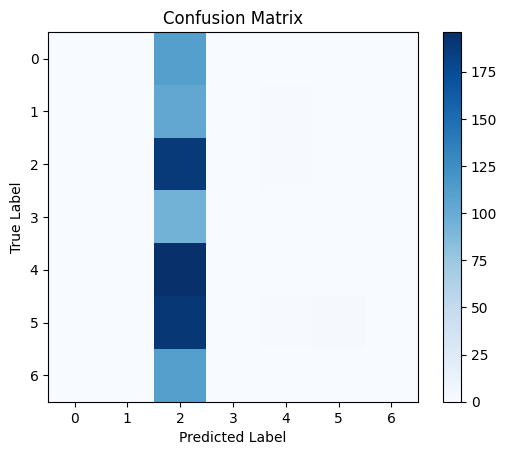

In [ ]:
conf_matrix = confusion_matrix(y_test, np.argmax(y_predict, axis=1))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Features Extraction - Mode 2 (Edges)

In [ ]:
dataset = DatasetLoader(root_dir=r'/content/drive/MyDrive/PR dataset/Scaled_Images',mode=2)

In [ ]:
i=0
dataX=[]
datay=[]
for X in dataset:
  i+=1
  dataX.append(np.concatenate((X['features'],X['color']),axis=None))
  datay.append(X['disease'])
  if i%1000==0:
    print(f'{i} samples read')

1000 samples read
2000 samples read
3000 samples read
4000 samples read
5000 samples read


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataX, datay, test_size=0.2, random_state=42)

In [ ]:
rfc = RandomForestClassifier(class_weight = 'balanced',random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
joblib.dump(rfc, '/content/drive/MyDrive/PR dataset/Trained_models/rbc_v02.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/rbc_v02.joblib']

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.63       111
         1.0       0.49      0.41      0.45       105
         2.0       0.48      0.57      0.52       190
         3.0       0.83      0.90      0.86        94
         4.0       0.53      0.60      0.56       196
         5.0       0.68      0.54      0.60       193
         6.0       0.91      0.85      0.88       111

    accuracy                           0.62      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.63      0.62      0.62      1000



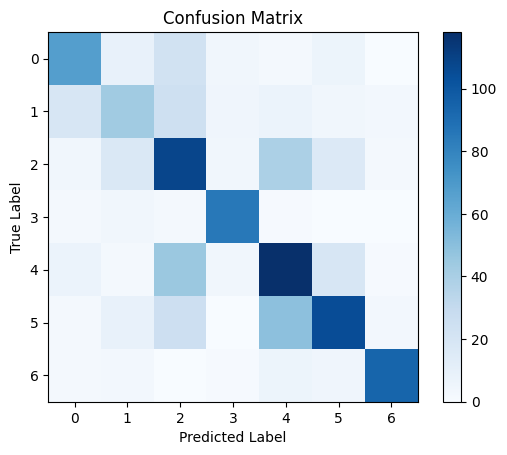

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train,y_train)

SVC(class_weight='balanced')

In [ ]:
joblib.dump(svm_model, '/content/drive/MyDrive/PR dataset/Trained Models/svm_v02.joblib')

['/content/drive/MyDrive/PR dataset/Trained Models/svm_v02.joblib']

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.39      0.39       111
         1.0       0.33      0.53      0.41       105
         2.0       0.39      0.45      0.42       190
         3.0       0.26      0.21      0.23        94
         4.0       0.49      0.49      0.49       196
         5.0       0.65      0.44      0.52       193
         6.0       0.52      0.44      0.48       111

    accuracy                           0.43      1000
   macro avg       0.43      0.42      0.42      1000
weighted avg       0.46      0.43      0.44      1000



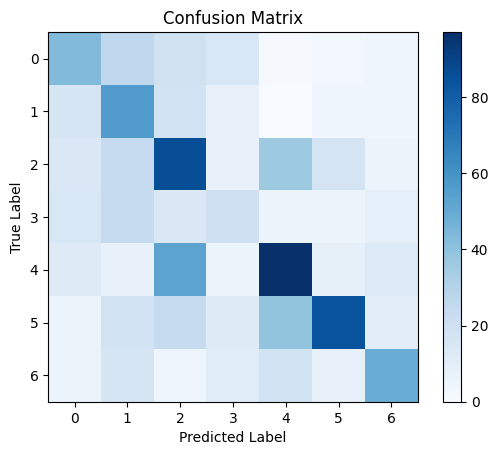

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
joblib.dump(xgbc, '/content/drive/MyDrive/PR dataset/Trained_models/catboost_v02.joblib')

['/content/drive/MyDrive/PR dataset/Trained_models/catboost_v02.joblib']

In [ ]:
y_pred = xgbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.56      0.60       111
         1.0       0.49      0.43      0.46       105
         2.0       0.49      0.56      0.52       190
         3.0       0.83      0.88      0.86        94
         4.0       0.53      0.59      0.56       196
         5.0       0.66      0.59      0.62       193
         6.0       0.92      0.86      0.89       111

    accuracy                           0.62      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.63      0.62      0.62      1000



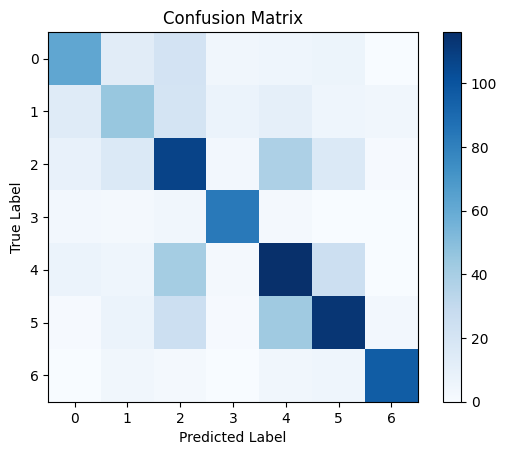

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_size = 3060
num_classes = 7

ann = models.Sequential()

ann.add(layers.InputLayer(input_shape=(input_size,)))

ann.add(layers.Dense(512, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(256, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(128, activation='relu'))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(num_classes, activation='softmax'))

ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

ann.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               1567232   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 7)                

In [ ]:
X_train = np.vstack(X_train)

In [ ]:
y_train = np.vstack(y_train)

In [ ]:
ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 5s 34ms/step - loss: 27.1530 - accuracy: 0.1719 - val_loss: 1.9347 - val_accuracy: 0.2037
Epoch 2/50
100/100 [==============================] - 4s 36ms/step - loss: 1.9579 - accuracy: 0.2150 - val_loss: 2.2929 - val_accuracy: 0.1988
Epoch 3/50
100/100 [==============================] - 3s 30ms/step - loss: 1.9239 - accuracy: 0.2053 - val_loss: 1.8810 - val_accuracy: 0.1975
Epoch 4/50
100/100 [==============================] - 3s 27ms/step - loss: 1.8935 - accuracy: 0.1947 - val_loss: 1.8729 - val_accuracy: 0.1975
Epoch 5/50
100/100 [==============================] - 2s 25ms/step - loss: 1.9224 - accuracy: 0.2000 - val_loss: 1.8714 - val_accuracy: 0.1975
Epoch 6/50
100/100 [==============================] - 2s 25ms/step - loss: 1.8915 - accuracy: 0.2053 - val_loss: 1.8702 - val_accuracy: 0.1975
Epoch 7/50
100/100 [==============================] - 3s 30ms/step - loss: 1.8892 - accuracy: 0.2031 - val_loss: 1.8693 - val_accuracy: 0.197

In [ ]:
ann.save('/content/drive/MyDrive/PR dataset/Trained_models/ann_v02.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
y_predict = ann.predict(np.vstack(X_test))

32/32 [==============================] - 0s 6ms/step


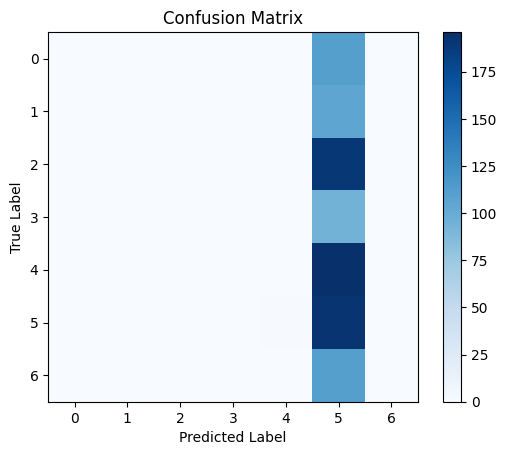

In [ ]:
conf_matrix = confusion_matrix(y_test, np.argmax(y_predict, axis=1))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()